注解：
1. 好像是用sklearn的随机森林分类器做点云分类，并没有使用深度学习; 
3. 用[pyntcloud](https://github.com/daavoo/pyntcloud)提取了各种各样的特征； 
4. 17个类别,使用的数据集：[Paris-rue-Madame database](http://cmm.mines-paristech.fr/Projects/TerraMobilita/rueMadame_database.zip)，数据集是两个ply文件分别充当训练集和测试集，都是1千万个点，排除地面点和默认点，剩下90万个点   


2019.03.14 调通，测试集 Accuracy: 0.9174709432905417

![Point Cloud](.\docu\Paris-rue-Madame-database.png)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyntcloud import PyntCloud
from pyntcloud import scalar_fields
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors.kde import KernelDensity

In [2]:
def preProcessData(cld):
    ##Cacluate 50 neighbours for determining the geometrical features of each point
    neigh=cld.get_neighbors(k=50)
    neigh.shape
    
    #注释的特征暂未使用，因为计算量有点大，目前只有geometrical features使用
    '''
    #kde=KernelDensity(kernel='gaussian',bandwidth=0.2).fit(cld.points[['x','y','z']])
    #density=kde.score_samples(cld.points[['x','y','z']])
    #cld.points.add(density,axis=1)

    #vox=cld.add_structure("voxelgrid")
    #vox_x=cld.add_scalar_field("voxel_x",voxelgrid_id=vox)
    #vox_y=cld.add_scalar_field("voxel_y",voxelgrid_id=vox)
    #vox_n=cld.add_scalar_field("voxel_n",voxelgrid_id=vox)
    #vox_z=cld.add_scalar_field("voxel_z",voxelgrid_id=vox)
    #inc=cld.add_scalar_field("inclination_degrees")
    #ori=cld.add_scalar_field("orientation_degrees")
    '''
    eig=   cld.add_scalar_field("eigen_values",k_neighbors=neigh)
    ani=   cld.add_scalar_field("anisotropy",ev=eig)
    cur=   cld.add_scalar_field("curvature",ev=eig)
    eigent=cld.add_scalar_field("eigenentropy",ev=eig)
    su=    cld.add_scalar_field("eigen_sum",ev=eig)
    lin=   cld.add_scalar_field("linearity",ev=eig)
    om=    cld.add_scalar_field("omnivariance",ev=eig)
    pla=   cld.add_scalar_field("planarity",ev=eig)
    sph=   cld.add_scalar_field("sphericity",ev=eig)
    return cld

# 训练集数据

In [3]:
## 加载训练集点云文件，加载后为pandas dataframe
cloud_train=PyntCloud.from_file("./data/rueMadame_database/GT_Madame1_2.ply")
print(cloud_train)

PyntCloud
10000000 points with 3 scalar fields
0 faces in mesh
0 kdtrees
0 voxelgrids
Centroid: -7.090676784515381, -124.74476623535156, 45.12932205200195
Other attributes:



In [4]:
cloud_train.points.head()

,x,y,z,reflectance,label,class
0,4.971637,-79.606361,43.221432,135.0,13,1
1,3.571728,-81.574989,42.445904,195.0,323,2
2,4.993350,-79.458405,43.303757,135.0,13,1
3,3.720481,-81.474182,42.465771,195.0,323,2
4,5.009287,-79.310478,43.387627,155.0,13,1


In [5]:
cloud_train.points.describe()

,x,y,z,reflectance,label,class
count,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07
mean,-7.090677e+00,-1.247448e+02,4.512932e+01,1.756020e+02,1.909009e+02,1.779957e+00
std,5.711431e+00,2.501587e+01,3.450395e+00,4.445920e+01,1.272395e+02,1.324664e+00
min,-2.431293e+01,-1.763527e+02,3.827620e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,-1.188609e+01,-1.470673e+02,4.262190e+01,1.350000e+02,6.200000e+01,1.000000e+00
50%,-6.908839e+00,-1.227259e+02,4.338097e+01,1.750000e+02,1.460000e+02,2.000000e+00
75%,-3.145591e+00,-1.038506e+02,4.698285e+01,1.950000e+02,3.230000e+02,2.000000e+00
max,1.249017e+01,-7.360262e+01,5.916681e+01,2.550000e+02,3.230000e+02,2.500000e+01


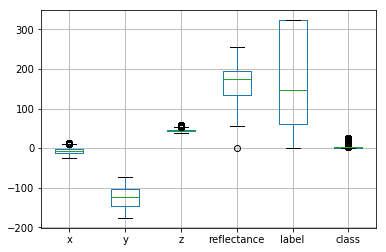

In [6]:
cloud_train.points.boxplot() # 图形化展示describe()

In [7]:
##Visualization of point cloud
# cloud_train.plot()

# 测试集数据

In [8]:
cloud_test=PyntCloud.from_file("./data/rueMadame_database/GT_Madame1_3.ply")
print(cloud_test)

PyntCloud
10000000 points with 3 scalar fields
0 faces in mesh
0 kdtrees
0 voxelgrids
Centroid: -12.104286193847656, -197.56027221679688, 46.1270637512207
Other attributes:



In [9]:
#cloud_test.plot()

# 点云地物分类标准 
1默认点，2地面点，345-低中高，7低噪，8关键，9临建，10桥梁，
11铁路，12公路，13不河流，14湖泊，15变电站，16导线，17铁塔
18交跨上，19交跨下，20地线，21其他，22船舶汽车，23其他线路
24共塔其他线，25通航河流，26铁路承力索，27引流线，28绝缘子

In [10]:
# 排除地面点和默认点
cloud_train=PyntCloud(cloud_train.points[cloud_train.points["class"]!=2])
cloud_train=PyntCloud(cloud_train.points[cloud_train.points["class"]!=1])

In [11]:
#用open3做三维网格下采样 voxel grid downsampling
#open3d.voxelgrid_downsampling(cloud,voxel=0.5)
cloud_train.points["class"].value_counts()

4     790822
10     81745
14     11463
9       3656
19      3030
15      2542
22      1915
20       983
24       491
23       384
25       379
21       111
0          3
Name: class, dtype: int64

In [12]:
# cloud_train.plot()

In [13]:
# 清理掉标签数据,防止数据泄露
cloud_train_target=cloud_train.points["class"]
cloud_train.points.drop(labels=["class"],inplace=True,axis=1)

cloud_train_pp = preProcessData(cloud_train)
cloud_train_pp.points.drop(labels=["label"],inplace=True,axis=1)
cloud_train_pp.points.drop(labels=["x","y","z","reflectance"],inplace=True,axis=1)
cloud_train_pp.points.head()
cloud_train_pp.points.to_csv("features_calculated_train.csv",index=False)

,e1(51),e2(51),e3(51),anisotropy(51),curvature(51),eigenentropy(51),eigen_sum(51),linearity(51),omnivariance(51),planarity(51),sphericity(51)
12801,0.006112,0.004801,0.001285,0.789751,0.105350,0.065343,0.012198,0.214527,0.003353,0.575223,0.210249
12831,0.005869,0.002909,0.001102,0.812179,0.111569,0.054649,0.009880,0.504367,0.002660,0.307812,0.187821
12860,0.006022,0.002450,0.001185,0.803149,0.122751,0.053501,0.009657,0.593193,0.002596,0.209956,0.196851
12888,0.006207,0.002183,0.001130,0.817957,0.118689,0.052587,0.009520,0.648256,0.002483,0.169701,0.182043
12914,0.004047,0.002875,0.000990,0.755292,0.125162,0.045970,0.007912,0.289576,0.002259,0.465716,0.244708


In [5]:
# sklearn的随机森林分类器
rfc = RandomForestClassifier()

In [15]:
rfc.fit(cloud_train_pp.points,cloud_train_target)

/home/huhongjun/anaconda2/envs/urban/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [16]:
# 预测训练数据
prediction=rfc.predict(cloud_train.points)
print("Accuracy:",accuracy_score(cloud_train_target,prediction))

Accuracy: 0.9821063280759066


In [6]:
import pickle
filename = "random_forest.sav"
pickle.dump(rfc,open(filename,'wb'))

rfc_model = pickle.load(open("random_forest.sav","rb"))

# Test Set Evaluation

测试集数据同样需要做数据预处理，提取相关特征。

In [17]:
#Downsampling not required as the dataset is already cleaned
#voxel grid downsampling will be done here
#open3d.voxelgrid_downsampling(cloud1,voxel=0.5)
#p linkage segmentation and shape distribution histogram

In [18]:
cloud_test=PyntCloud(cloud_test.points[cloud_test.points["class"]!=2])
cloud_test=PyntCloud(cloud_test.points[cloud_test.points["class"]!=1])

cloud_test_target=cloud_test.points["class"]
cloud_test.points.drop(labels=["class"],inplace=True,axis=1)

cloud_test_pp = preProcessData(cloud_test)
cloud_test_pp.points.drop(labels=["label"],inplace=True,axis=1)
cloud_test_pp.points.drop(labels=["x","y","z","reflectance"],inplace=True,axis=1)  

In [19]:
prediction_test=rfc.predict(cloud_test_pp.points)
print("Accuracy:",accuracy_score(cloud_test_target,prediction_test))

Accuracy: 0.9187730621434403
